# Redes Neuronales - Aprendizaje

## Introducción

En este ejemplo se implementara el algoritmo de backpropagation, o propagación hacia atras para redes neuronales y se aplicara a la tarea del reconocimiento de digitos manuscritos.

In [1]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# library written for this exercise providing additional functions for assignment submission, and others
# import utils


# tells matplotlib to embed plots within the notebook
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [24]:
import sys

sys.path.insert(0, '/content/gdrive/MyDrive/Colab Notebooks/machine learning/datasets')
sys.path.insert(1, '/content/gdrive/MyDrive/Colab Notebooks/machine learning/03 redes neuronales')

# from utils import displayData,

In [25]:
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Displays 2D data stored in X in a nice grid.
    """
    # Compute rows, cols
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        # Display Image
        h = ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                      cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')

## Red Neuronal

En el ejercicio anterior se implemento la propagacion hacia adelante para realizar predicciones en este ejercicio se implementara la propagacion hacia atraz para entrenar para aprender los parametros para la red neuronal.

Se inicia el ejercicio cargando el dataset.

In [27]:
#  los datos de entrenamiento se almacenan en los arreglos X, y
# data = loadmat(os.path.join('/content/gdrive/MyDrive/Colab Notebooks/machine learning/data', 'ex4data1.mat'))
data = loadmat('/content/gdrive/MyDrive/Colab Notebooks/machine learning/datasets/ex4data1.mat')
# print(data['y'])
# print(data['y'].ravel())

X, y = data['X'], data['y'].ravel()

# Se cambia el valor de 10 por 0 de y
y[y == 10] = 0

# Numero de ejemplos de entrenamiento
m = y.size

print(m)

5000


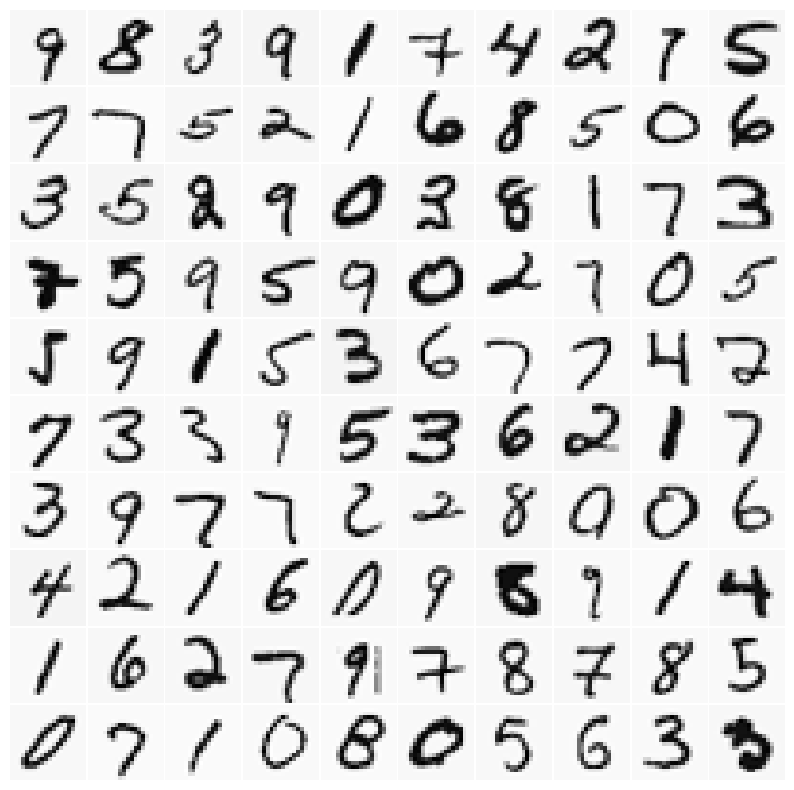

In [28]:
# Se seleccionan 100 datos para ser visualizados
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

displayData(sel)

### 1.2 Representación del modelo

![](Figures/neural_network.png)

La red neuronal tiene 3 capas: una capa de entrada, una capa oculta y una capa de salida. Recuerde que las entradas son valores de píxeles de digitos de imagenes. Dado que las imágenes tienen un tamaño de $20 \times 20$, esto nos da 400 unidades de capa de entrada (sin contar la unidad de oscilación adicional que siempre genera +1). Los datos de entrenamiento se cargaron en las variables `X` y `y` anteriores.

Se proporciona un conjunto de parámetros de red ($\Theta^{(1)}, \Theta^{(2)}$) ya entrenados. Estos se almacenan en `ex4weights.mat` y se cargarán en la siguiente celda de este cuaderno en `Theta1` y `Theta2`. Los parámetros tienen dimensiones que están dimensionadas para una red neuronal con 25 unidades en la segunda capa y 10 unidades de salida (correspondientes a las clases de 10 dígitos).

In [29]:
# Configurando parametros necesario
input_layer_size  = 400  # Entrada de imagenes de digitos de 20x20
hidden_layer_size = 25   # 25 unidades ocultas
num_labels = 10          # 10 etiquetas, de 0 a 9

# carga los pesos en las variables Theta1 y Theta2
# weights = loadmat(os.path.join('/content/gdrive/MyDrive/Colab Notebooks/machine learning/data', 'ex4weights.mat'))
weights = loadmat('/content/gdrive/MyDrive/Colab Notebooks/machine learning/datasets/ex4weights.mat')
# print(weights['Theta1'][0].shape)
# print(weights['Theta1'][0])
# print(np.roll(weights['Theta1'][0], 1, axis=0))
# Theta1 tiene un tamaño de 25x401
# Theta2 tiene un tamañó de 10x26
Theta1, Theta2 = weights['Theta1'], weights['Theta2']

# se intercambia la ultima columa con la primera de Theta2, por cuestiones de indices que utiliza MATLAB
# print(Theta2)
# print(np.roll(Theta2, 1, axis=0))

Theta2 = np.roll(Theta2, 1, axis=0)

# Desenrollar parámetros
nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()])

In [30]:
a = np.array([1,2,3])
b = np.array([4,5,6])
print(np.concatenate([a.ravel(), b.ravel()]))

[1 2 3 4 5 6]


<a id="section1"></a>
### 1.3 Propagación hacia adelante y funcion de costo

Ahora se implementa la funcion de costo y gradiente para la red neuronal `nnCostFunction`.

La función de costo para la red neuronal (sin regularización) es:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right]$$

Donde $h_\theta \left( x^{(i)} \right)$ se calcula como se muestra en la figura de la red neuronal anterior, y K = 10 es el número total de etiquetas posibles. Tenga en cuenta que $h_\theta(x^{(i)})_k = a_k^{(3)}$ es la activación (valor de salida) de la unidad de salida $k^{th}$. Además, recuerde que mientras que las etiquetas originales (en la variable y) eran 0, 1, ..., 9, con el propósito de entrenar una red neuronal, necesitamos codificar las etiquetas como vectores que contienen solo valores 0 o 1, entonces:

$$ y =
\begin{bmatrix} 1 \\ 0 \\ 0 \\\vdots \\ 0 \end{bmatrix}, \quad
\begin{bmatrix} 0 \\ 1 \\ 0 \\ \vdots \\ 0 \end{bmatrix}, \quad \cdots  \quad \text{or} \qquad
\begin{bmatrix} 0 \\ 0 \\ 0 \\ \vdots \\ 1 \end{bmatrix}.
$$

Por ejemplo, si $x^{(i)}$ es una imagen del dígito 5, entonces el $y^{(i)}$ correspondiente (que debe usar con la función de costo) debe ser un vector de 10 dimensiones con $y_5 = 1$, y los otros elementos iguales a 0.

<div class="alert alert-box alert-warning">
Nota de implementación: ** La matriz $X$ contiene los ejemplos en filas (es decir, X [i ,:] es el i-ésimo ejemplo de entrenamiento $x^{(i)}$, expresado como $n \times 1$ vector.) Cuando complete el código en `nnCostFunction`, deberá agregar la columna de 1 a la matriz X. Los parámetros para cada unidad en la red neuronal se representan en Theta1 y Theta2 como una fila. Específicamente, la primera fila de Theta1 corresponde a la primera unidad oculta en la segunda capa. Puede utilizar un bucle for sobre los ejemplos para calcular el costo.
    
</div>
<a id="nnCostFunction"></a>

In [9]:
def sigmoid(z):
    """
    Computes the sigmoid of z.
    """
    return 1.0 / (1.0 + np.exp(-z))


def sigmoidGradient(z):

    g = np.zeros(z.shape)

    g = sigmoid(z) * (1 - sigmoid(z))

    return g

In [10]:
def nnCostFunction(nn_params,
                   input_layer_size,
                   hidden_layer_size,
                   num_labels,
                   X, y, lambda_=0.0):

  # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
  # for our 2 layer neural network
  Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))

  Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))

  m = y.size

  J = 0
  Theta1_grad = np.zeros(Theta1.shape)
  Theta2_grad = np.zeros(Theta2.shape)

  a1 = np.concatenate([np.ones((m, 1)), X], axis=1)

  a2 = sigmoid(a1.dot(Theta1.T))
  a2 = np.concatenate([np.ones((a2.shape[0], 1)), a2], axis=1)

  a3 = sigmoid(a2.dot(Theta2.T))

  print("-"*20)
  print(y.shape)
  print(y.reshape(-1))
  print("-"*20)
  y_matrix = y.reshape(-1)
  print(y.shape)
  y_matrix = np.eye(num_labels)[y_matrix]
  print(y_matrix)

  temp1 = Theta1
  temp2 = Theta2

  # Agregar el termino de regularización

  reg_term = (lambda_ / (2 * m)) * (np.sum(np.square(temp1[:, 1:])) + np.sum(np.square(temp2[:, 1:])))

  J = (-1 / m) * np.sum((np.log(a3) * y_matrix) + np.log(1 - a3) * (1 - y_matrix)) + reg_term

  # Backpropogation

  delta_3 = a3 - y_matrix
  delta_2 = delta_3.dot(Theta2)[:, 1:] * sigmoidGradient(a1.dot(Theta1.T))

  Delta1 = delta_2.T.dot(a1)
  Delta2 = delta_3.T.dot(a2)

  # Agregar regularización al gradiente
  Theta1_grad = (1 / m) * Delta1
  Theta1_grad[:, 1:] = Theta1_grad[:, 1:] + (lambda_ / m) * Theta1[:, 1:]

  Theta2_grad = (1 / m) * Delta2
  Theta2_grad[:, 1:] = Theta2_grad[:, 1:] + (lambda_ / m) * Theta2[:, 1:]

  # ===================== Alterntate solutions =====================
  # my_final_matrix = np.zeros(a3.shape)
  # for c in np.arange(num_labels):
  #    my_final_matrix[:, c] = (np.log(a3[:, c]) * (y == c)) + (np.log(1 - a3[:, c]) * (1 - (y == c)))
  #J = (-1 / m) * np.sum(my_final_matrix)
  # ================================================================

  # ================================================================
  # Unroll gradients
  # grad = np.concatenate([Theta1_grad.ravel(order=order), Theta2_grad.ravel(order=order)])

  grad = np.concatenate([Theta1_grad.ravel(), Theta2_grad.ravel()])

  return J, grad

Una vez terminado, se llama a `nnCostFunction` usando el conjunto de parámetros cargados para` Theta1` y `Theta2`. Debería ver que el costo es de aproximadamente 0.287629.

In [11]:
lambda_ = 0
J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_)
print('Costo en parametros (cargado de ex4weights): %.6f ' % J)
print('El costo debe esta cercano a               : 0.287629')

--------------------
(5000,)
[0 0 0 ... 9 9 9]
--------------------
(5000,)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Costo en parametros (cargado de ex4weights): 0.287629 
El costo debe esta cercano a               : 0.287629


<a id="section2"></a>
### 1.4 Funcion de costo regularizada

La funcion de costo para una red neuronal con regularizacion esta dado por:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right] + \frac{\lambda}{2 m} \left[ \sum_{j=1}^{25} \sum_{k=1}^{400} \left( \Theta_{j,k}^{(1)} \right)^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} \left( \Theta_{j,k}^{(2)} \right)^2 \right] $$

La red neuronal solo tendrá 3 capas: una capa de entrada, una capa oculta y una capa de salida. Sin embargo, el código debería funcionar para cualquier cantidad de unidades de entrada, unidades ocultas y unidades de salida. Mientras se han enumerado explícitamente los índices anteriores para $\ Theta^{(1)}$ y $\Theta^{(2)}$ para mayor claridad, tenga en cuenta que su código debería funcionar en general con $\Theta^{(1)}$ y $\Theta^{(2)} $ de cualquier tamaño. Hay que tomar en cuenta que no se debe regularizar los términos que corresponden al sesgo. Para las matrices `Theta1` y` Theta2`, esto corresponde a la primera columna de cada matriz.

Terminado, la siguiente celda llamará a `nnCostFunction` usando el conjunto cargado de parámetros para `Theta1` y `Theta2`, y $\lambda = 1$. El costo deberia ser aproximadamente 0.383770.

In [12]:
# Weight regularization parameter (we set this to 1 here).
lambda_ = 1
# print(nn_params)
J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                      num_labels, X, y, lambda_)

print('Costo en parametros (cargado de ex4weights): %.6f' % J)
print('El costo debe esta cercano a               : 0.383770')

--------------------
(5000,)
[0 0 0 ... 9 9 9]
--------------------
(5000,)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Costo en parametros (cargado de ex4weights): 0.383770
El costo debe esta cercano a               : 0.383770


## 2 Backpropagation (Propagación hacia atraz)

En esta parte del ejercicio, implementará el algoritmo de retropropagación para calcular el gradiente de la función de costo de la red neuronal. Se deberá actualizar la función `nnCostFunction` para que devuelva un valor apropiado para `grad`. Una vez que haya calculado el gradiente, podrá entrenar la red neuronal minimizando la función de costo $J(\theta)$ utilizando un optimizador avanzado como `scipy`'s` optimize.minimize`.

Primero se implementará el algoritmo de retropropagación para calcular los gradientes de los parámetros de la red neuronal (no regularizada). Una vez que se haya verificado que su cálculo de gradiente para el caso no regularizado es correcto, se implementará el gradiente para la red neuronal regularizada.

<a id="section3"></a>
### 2.1 Gradiente de la sigmoide

El gradiente para la función sigmoidea puede ser calculada por:

$$ g'(z) = \frac{d}{dz} g(z) = g(z)\left(1-g(z)\right) $$

donde

$$ \text{sigmoid}(z) = g(z) = \frac{1}{1 + e^{-z}} $$

En la siguiente celda se llama a `sigmoidGradient` en un vector dado `z`. Intente probar algunos valores llamando a `sigmoidGradient (z)`. Para valores grandes (tanto positivos como negativos) de z, el gradiente debe ser cercano a 0. Cuando $z = 0$, el gradiente debe ser exactamente 0.25. El código también debería funcionar con vectores y matrices. Para una matriz, su función debe realizar la función de gradiente sigmoide en cada elemento.

In [13]:
z = np.array([-1, -0.5, 0, 0.5, 1])
g = sigmoidGradient(z)
print('Gradiente sigmoide evaluada con [-1 -0.5 0 0.5 1]:\n  ')
print(g)

Gradiente sigmoide evaluada con [-1 -0.5 0 0.5 1]:
  
[0.19661193 0.23500371 0.25       0.23500371 0.19661193]


## 2.2 Random Initialization

Al entrenar redes neuronales, es importante inicializar aleatoriamente los parámetros para romper la simetría. Una estrategia eficaz para la inicialización aleatoria es seleccionar aleatoriamente valores para $\Theta^{(l)}$ uniformemente en el rango $[-\epsilon_{init}, \epsilon_ {init}]$. Debe usar $\epsilon_{init}=0.12$. Este rango de valores asegura que los parámetros se mantengan pequeños y hace que el aprendizaje sea más eficiente.

<div class="alert alert-box alert-warning">
Una estrategia eficaz para elegir $\epsilon_{init}$ es basarlo en la cantidad de unidades en la red. Una buena elección de $\epsilon_{init}$ es $\epsilon_{init} = \frac{\sqrt{6}}{\sqrt{L_{in} + L_{out}}}$ donde $L_{in} = s_l$ y $L_{out} = s_{l+1}$ son el número de unidades en las capas adyacentes a $\Theta^{l}$.
</div>

```python
# Randomly initialize the weights to small values
W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init
```
Tenga en cuenta ue se da a la función un argumento para $\epsilon$ con el valor predeterminado `epsilon_init = 0.12`.

In [14]:
def randInitializeWeights(L_in, L_out, epsilon_init=0.12):
    """
    Randomly initialize the weights of a layer in a neural network.

    Parameters
    ----------
    L_in : int
        Number of incomming connections.

    L_out : int
        Number of outgoing connections.

    epsilon_init : float, optional
        Range of values which the weight can take from a uniform
        distribution.

    Returns
    -------
    W : array_like
        The weight initialiatized to random values.  Note that W should
        be set to a matrix of size(L_out, 1 + L_in) as
        the first column of W handles the "bias" terms."""


    W = np.zeros((L_out, 1 + L_in))
    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init

    return W

In [15]:
print('Inicialización de parámetros de redes neuronales...')

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

# Desenrrollr parametros
initial_nn_params = np.concatenate([initial_Theta1.ravel(), initial_Theta2.ravel()], axis=0)

Inicialización de parámetros de redes neuronales...


<a id="section4"></a>
### 2.4 Backpropagation

![](Figures/ex4-backpropagation.png)

Ahora, se implementará el algoritmo de retropropagación. Recuerde que la intuición detrás del algoritmo de retropropagación es la siguiente. Dado un ejemplo de entrenamiento $(x^{(t)}, y^{(t)})$, primero ejecutaremos un "pase hacia adelante" para calcular todas las activaciones en toda la red, incluido el valor de salida de la hipótesis $h_\theta(x)$. Luego, para cada nodo $j$ en la capa $l$, se busca calcular un "término de error" $\delta_j^{(l)}$ que mide cuánto ese nodo fue "responsable" de cualquier error en la salida.

Para un nodo de salida, se puede medir directamente la diferencia entre la activación de la red y el valor objetivo real, y usar eso para definir $\delta_j^{(3)}$ (ya que la capa 3 es la capa de salida). Para las unidades ocultas, calculará $\delta_j^{(l)}$ basándose en un promedio ponderado de los términos de error de los nodos en la capa $(l+1)$. En detalle, aquí está el algoritmo de retropropagación (también representado en la figura anterior). Debe implementar los pasos 1 a 4 en un ciclo que procese un ejemplo a la vez. Concretamente, debe implementar un bucle for `for t in range(m)` y colocar los pasos 1-4 a continuación dentro del bucle for, con la iteración $t^{th}$ realizando el cálculo en el $t^{th}$ ejemplo de entrenamiento $(x^{(t)}, y^{(t)})$. El paso 5 dividirá los gradientes acumulados por $m$ para obtener los gradientes para la función de costo de la red neuronal.

1. Establecer los valores de la capa de entrada $(a^{(1)})$ con los $t^{th }$ ejemplos de entrenamiento $x^{(t)}$. Ejecutar un paso de propagacion hacia adelante, calculando la activación $(z^{(2)}, a^{(2)}, z^{(3)}, a^{(3)})$ para las capas 2 y 3. Recordad que se debe añadir el termino de oscilacion `+1` termino que asegura que los vectores de de las capas de activacion $a^{(1)}$ y $a^{(2)}$ tambien incluyan una unidad de oscilacion (bias). En `numpy`, si a_1 es un columna de matriz, agregar una columna se locgra con `a_1 = np.concatenate([np.ones((m, 1)), a_1], axis=1)`.

1. Por cada unidad de salida $k$ en la capa 3 (La capa de salida), establece
$$\delta_k^{(3)} = \left(a_k^{(3)} - y_k \right)$$
donde $y_k \in \{0, 1\}$ indica si el ejemplo de entrenamiento actual pertenece a la clase $k$ $(y_k = 1)$, o si pertenece a una clase diferente $(y_k = 0)$. Puede encontrar útiles las matrices lógicas para esta tarea (explicada en el ejercicio de programación anterior).

1. Para la capa oculta se establece $l = 2$,
$$ \delta^{(2)} = \left( \Theta^{(2)} \right)^T \delta^{(3)} * g'\left(z^{(2)} \right)$$
Tomar en cuenta que el simbolo  $*$ realiza multiplicaciones de elementos en `numpy`.

1. Acumule el gradiente de este ejemplo usando la siguiente fórmula. Tenga en cuenta que debe omitir o eliminar $\delta_0^{(2)}$. En `numpy`, eliminando $\delta_0^{(2)}$ corresponde a `delta_2 = delta_2[1:]`.

1. Obtenga el gradiente (no regularizado) para la función de costo de la red neuronal dividiendo los gradientes acumulados por $\frac{1}{m}$:
$$ \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)}$$

<div class="alert alert-box alert-warning">
**Consejo de Python/Numpy **: debe implementar el algoritmo backpropagation solo después de haber completado con éxito las funciones de forwardpropagation y costo. Al implementar el algoritmo de retropropagación, a menudo es útil utilizar la función `shape` para imprimir las formas de las variables con las que está trabajando si se encuentra con errores de discrepancia de dimensión.
</div>

Después de que haya implementado el algoritmo de retropropagación, se procede a ejecutar la verificación del gradiente en la implementación. La verificación de gradiente permitirá aumentar la confianza en que el código calcula los gradientes correctamente.

### 2.4  Comprobación del gradiente

En la red neuronal, se está minimizando la función de costo $J(\Theta)$. Para realizar una verificación de gradiente en sus parámetros, se puede imaginar "desenrollar" los parámetros $\Theta^{(1)}$, $\Theta^{(2)}$ en un vector largo $\theta$. Al hacerlo, se puede pensar que la función de costo es $J(\Theta)$ y usar el siguiente procedimiento de verificación de gradiente.

Suponga que tiene una función $f_i(\theta)$ que supuestamente calcula $\frac{\partial}{\partial\theta_i} J(\theta)$; le gustaría comprobar si $f_i$ está generando valores derivados correctos.

$$
\text{Let } \theta^{(i+)} = \theta + \begin{bmatrix} 0 \\ 0 \\ \vdots \\ \epsilon \\ \vdots \\ 0 \end{bmatrix}
\quad \text{and} \quad \theta^{(i-)} = \theta - \begin{bmatrix} 0 \\ 0 \\ \vdots \\ \epsilon \\ \vdots \\ 0 \end{bmatrix}
$$

Entonces, $\theta^{(i+)}$ es lo mismo que $\theta$, excepto que su elemento $i^{th}$ se ha incrementado en $\epsilon$. De manera similar, $\theta^{(i−)}$ el vector correspondiente con el elemento $i^{th}$ disminuido en $\epsilon$. Ahora se puede verificar numericamente la exactitud de $f_i(\theta)$ comprobando, para cada $i$, que:

$$ f_i\left( \theta \right) \approx \frac{J\left( \theta^{(i+)}\right) - J\left( \theta^{(i-)} \right)}{2\epsilon} $$

El grado en el que estos dos valores deben aproximarse entre sí dependerá de los detalles de $J$. Pero suponiendo que $\epsilon = 10^{-4}$, normalmente encontrará que los lados izquierdo y derecho de lo anterior coincidirán con al menos 4 dígitos significativos (y a menudo muchos más).

Se tiene implementada la funcion de calculo numerico del gradiente en `computeNumericalGradient` (dentro del archivo `utils.py`).

En la siguiente celda, ejecutaremos la función provista `checkNNGradients` que creará una pequeña red neuronal y un conjunto de datos que se utilizará para verificar sus gradientes. Si su implementación de retropropagación es correcta, debería ver una diferencia relativa menor que 1e-9.

<div class="alert alert-box alert-success">
** Consejo práctico **: al realizar la verificación de gradientes, es mucho más eficiente utilizar una pequeña red neuronal con un número relativamente pequeño de unidades de entrada y unidades ocultas, por lo que tiene un número relativamente pequeño
de parámetros. Cada dimensión de $\theta$ requiere dos evaluaciones de la función de costo y esto puede resultar costoso. En la función `checkNNGradients`, nuestro código crea un pequeño modelo aleatorio y un conjunto de datos que se usa con `computeNumericalGradient` para verificar el gradiente. Además, una vez que esté seguro de que sus cálculos de gradiente son correctos, debe desactivar la verificación de gradiente antes de ejecutar su algoritmo de aprendizaje.
</div>

<div class="alert alert-box alert-success">
** Sugerencia práctica: ** La verificación del gradiente funciona para cualquier función en la que esté calculando el costo y el gradiente. Concretamente, puede usar la misma función `computeNumericalGradient` para verificar si sus implementaciones de gradiente para los otros ejercicios también son correctas (por ejemplo, la función de costo de regresión logística).
</div>

In [16]:
def debugInitializeWeights(fan_out, fan_in):
    """
    Initialize the weights of a layer with fan_in incoming connections and fan_out outgoings
    connections using a fixed strategy. This will help you later in debugging.

    Note that W should be set a matrix of size (1+fan_in, fan_out) as the first row of W handles
    the "bias" terms.

    Parameters
    ----------
    fan_out : int
        The number of outgoing connections.

    fan_in : int
        The number of incoming connections.

    Returns
    -------
    W : array_like (1+fan_in, fan_out)
        The initialized weights array given the dimensions.
    """
    # Initialize W using "sin". This ensures that W is always of the same values and will be
    # useful for debugging
    W = np.sin(np.arange(1, 1 + (1+fan_in)*fan_out))/10.0
    W = W.reshape(fan_out, 1+fan_in, order='F')
    return W

def computeNumericalGradient(J, theta, e=1e-4):
    """
    Computes the gradient using "finite differences" and gives us a numerical estimate of the
    gradient.

    Parameters
    ----------
    J : func
        The cost function which will be used to estimate its numerical gradient.

    theta : array_like
        The one dimensional unrolled network parameters. The numerical gradient is computed at
         those given parameters.

    e : float (optional)
        The value to use for epsilon for computing the finite difference.

    Notes
    -----
    The following code implements numerical gradient checking, and
    returns the numerical gradient. It sets `numgrad[i]` to (a numerical
    approximation of) the partial derivative of J with respect to the
    i-th input argument, evaluated at theta. (i.e., `numgrad[i]` should
    be the (approximately) the partial derivative of J with respect
    to theta[i].)
    """
    numgrad = np.zeros(theta.shape)
    perturb = np.diag(e * np.ones(theta.shape))
    for i in range(theta.size):
        loss1, _ = J(theta - perturb[:, i])
        loss2, _ = J(theta + perturb[:, i])
        numgrad[i] = (loss2 - loss1)/(2*e)
    return numgrad


def checkNNGradients(nnCostFunction, lambda_=0):
    """
    Creates a small neural network to check the backpropagation gradients. It will output the
    analytical gradients produced by your backprop code and the numerical gradients
    (computed using computeNumericalGradient). These two gradient computations should result in
    very similar values.

    Parameters
    ----------
    nnCostFunction : func
        A reference to the cost function implemented by the student.

    lambda_ : float (optional)
        The regularization parameter value.
    """
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5

    # We generate some 'random' test data
    Theta1 = debugInitializeWeights(hidden_layer_size, input_layer_size)
    Theta2 = debugInitializeWeights(num_labels, hidden_layer_size)

    # Reusing debugInitializeWeights to generate X
    X = debugInitializeWeights(m, input_layer_size - 1)
    y = np.arange(1, 1+m) % num_labels
    # print(y)
    # Unroll parameters
    nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()])

    # short hand for cost function
    costFunc = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size,
                                        num_labels, X, y, lambda_)
    cost, grad = costFunc(nn_params)
    numgrad = computeNumericalGradient(costFunc, nn_params)

    # Visually examine the two gradient computations.The two columns you get should be very similar.
    print(np.stack([numgrad, grad], axis=1))
    print('The above two columns you get should be very similar.')
    print('(Left-Your Numerical Gradient, Right-Analytical Gradient)\n')

    # Evaluate the norm of the difference between two the solutions. If you have a correct
    # implementation, and assuming you used e = 0.0001 in computeNumericalGradient, then diff
    # should be less than 1e-9.
    diff = np.linalg.norm(numgrad - grad)/np.linalg.norm(numgrad + grad)

    print('If your backpropagation implementation is correct, then \n'
          'the relative difference will be small (less than 1e-9). \n'
          'Relative Difference: %g' % diff)


In [17]:
checkNNGradients(nnCostFunction)

--------------------
(5,)
[1 2 0 1 2]
--------------------
(5,)
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
--------------------
(5,)
[1 2 0 1 2]
--------------------
(5,)
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
--------------------
(5,)
[1 2 0 1 2]
--------------------
(5,)
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
--------------------
(5,)
[1 2 0 1 2]
--------------------
(5,)
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
--------------------
(5,)
[1 2 0 1 2]
--------------------
(5,)
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
--------------------
(5,)
[1 2 0 1 2]
--------------------
(5,)
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
--------------------
(5,)
[1 2 0 1 2]
--------------------
(5,)
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
--------------------
(5,)
[1 2 0 1 2]
--------------------
(5,)
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


<a id="section5"></a>
### 2.5 Regularized Neural Network

After you have successfully implemented the backpropagation algorithm, you will add regularization to the gradient. To account for regularization, it turns out that you can add this as an additional term *after* computing the gradients using backpropagation.

Specifically, after you have computed $\Delta_{ij}^{(l)}$ using backpropagation, you should add regularization using

$$ \begin{align}
& \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)} & \qquad \text{for } j = 0 \\
& \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)} + \frac{\lambda}{m} \Theta_{ij}^{(l)} & \qquad \text{for } j \ge 1
\end{align}
$$

Note that you should *not* be regularizing the first column of $\Theta^{(l)}$ which is used for the bias term. Furthermore, in the parameters $\Theta_{ij}^{(l)}$, $i$ is indexed starting from 1, and $j$ is indexed starting from 0. Thus,

$$
\Theta^{(l)} = \begin{bmatrix}
\Theta_{1,0}^{(i)} & \Theta_{1,1}^{(l)} & \cdots \\
\Theta_{2,0}^{(i)} & \Theta_{2,1}^{(l)} & \cdots \\
\vdots &  ~ & \ddots
\end{bmatrix}
$$

[Now modify your code that computes grad in `nnCostFunction` to account for regularization.](#nnCostFunction)

After you are done, the following cell runs gradient checking on your implementation. If your code is correct, you should expect to see a relative difference that is less than 1e-9.

In [18]:
#  Check gradients by running checkNNGradients
lambda_ = 3
checkNNGradients(nnCostFunction, lambda_)

# Also output the costFunction debugging values
debug_J, _  = nnCostFunction(nn_params, input_layer_size,
                          hidden_layer_size, num_labels, X, y, lambda_)

print('\n\nCost at (fixed) debugging parameters (w/ lambda = %f): %f ' % (lambda_, debug_J))
print('(for lambda = 3, this value should be about 0.576051)')

--------------------
(5,)
[1 2 0 1 2]
--------------------
(5,)
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
--------------------
(5,)
[1 2 0 1 2]
--------------------
(5,)
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
--------------------
(5,)
[1 2 0 1 2]
--------------------
(5,)
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
--------------------
(5,)
[1 2 0 1 2]
--------------------
(5,)
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
--------------------
(5,)
[1 2 0 1 2]
--------------------
(5,)
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
--------------------
(5,)
[1 2 0 1 2]
--------------------
(5,)
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
--------------------
(5,)
[1 2 0 1 2]
--------------------
(5,)
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
--------------------
(5,)
[1 2 0 1 2]
--------------------
(5,)
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


### 2.6 Learning parameters using `scipy.optimize.minimize`

After you have successfully implemented the neural network cost function
and gradient computation, the next step we will use `scipy`'s minimization to learn a good set parameters.

In [19]:
#  After you have completed the assignment, change the maxiter to a larger
#  value to see how more training helps.
options= {'maxiter': 100}

#  You should also try different values of lambda
lambda_ = 1

# Create "short hand" for the cost function to be minimized
costFunction = lambda p: nnCostFunction(p, input_layer_size,
                                        hidden_layer_size,
                                        num_labels, X, y, lambda_)

# Now, costFunction is a function that takes in only one argument
# (the neural network parameters)
res = optimize.minimize(costFunction, initial_nn_params, jac=True, method='TNC', options=options)

# get the solution of the optimization
nn_params = res.x

# Obtain Theta1 and Theta2 back from nn_params
Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                    (hidden_layer_size, (input_layer_size + 1)))

Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                    (num_labels, (hidden_layer_size + 1)))

--------------------
(5000,)
[0 0 0 ... 9 9 9]
--------------------
(5000,)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


<ipython-input-19-e4c04d22dc03>:15: OptimizeWarning: Unknown solver options: maxiter
  res = optimize.minimize(costFunction, initial_nn_params, jac=True, method='TNC', options=options)


Se han truncado las últimas 5000 líneas del flujo de salida.
(5000,)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
--------------------
(5000,)
[0 0 0 ... 9 9 9]
--------------------
(5000,)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
--------------------
(5000,)
[0 0 0 ... 9 9 9]
--------------------
(5000,)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
--------------------
(5000,)
[0 0 0 ... 9 9 9]
--------------------
(5000,)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
--------------------
(5000,)
[0 0 0 ... 9 9 9]
--------------------
(5000,)
[[1

After the training completes, we will proceed to report the training accuracy of your classifier by computing the percentage of examples it got correct. If your implementation is correct, you should see a reported
training accuracy of about 95.3% (this may vary by about 1% due to the random initialization). It is possible to get higher training accuracies by training the neural network for more iterations. We encourage you to try
training the neural network for more iterations (e.g., set `maxiter` to 400) and also vary the regularization parameter $\lambda$. With the right learning settings, it is possible to get the neural network to perfectly fit the training set.

In [20]:
def predict(Theta1, Theta2, X):
    """
    Predict the label of an input given a trained neural network
    Outputs the predicted label of X given the trained weights of a neural
    network(Theta1, Theta2)
    """
    # Useful values
    m = X.shape[0]
    num_labels = Theta2.shape[0]

    # You need to return the following variables correctly
    p = np.zeros(m)
    h1 = sigmoid(np.dot(np.concatenate([np.ones((m, 1)), X], axis=1), Theta1.T))
    h2 = sigmoid(np.dot(np.concatenate([np.ones((m, 1)), h1], axis=1), Theta2.T))
    p = np.argmax(h2, axis=1)
    return p

In [21]:
pred = predict(Theta1, Theta2, X)
print('Training Set Accuracy: %f' % (np.mean(pred == y) * 100))

Training Set Accuracy: 99.680000


In [22]:
print(X.shape)
print(X[:5, :].shape)
pred = predict(Theta1, Theta2, X[3000:3110, :])
print(pred)
print('Training Set Accuracy: %f' % (np.mean(pred == y[3000:3110]) * 100))

(5000, 400)
(5, 400)
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
Training Set Accuracy: 100.000000


## 3 Visualizing the Hidden Layer

One way to understand what your neural network is learning is to visualize what the representations captured by the hidden units. Informally, given a particular hidden unit, one way to visualize what it computes is to find an input $x$ that will cause it to activate (that is, to have an activation value
($a_i^{(l)}$) close to 1). For the neural network you trained, notice that the $i^{th}$ row of $\Theta^{(1)}$ is a 401-dimensional vector that represents the parameter for the $i^{th}$ hidden unit. If we discard the bias term, we get a 400 dimensional vector that represents the weights from each input pixel to the hidden unit.

Thus, one way to visualize the “representation” captured by the hidden unit is to reshape this 400 dimensional vector into a 20 × 20 image and display it (It turns out that this is equivalent to finding the input that gives the highest activation for the hidden unit, given a “norm” constraint on the input (i.e., $||x||_2 \le 1$)).

The next cell does this by using the `displayData` function and it will show you an image with 25 units,
each corresponding to one hidden unit in the network. In your trained network, you should find that the hidden units corresponds roughly to detectors that look for strokes and other patterns in the input.

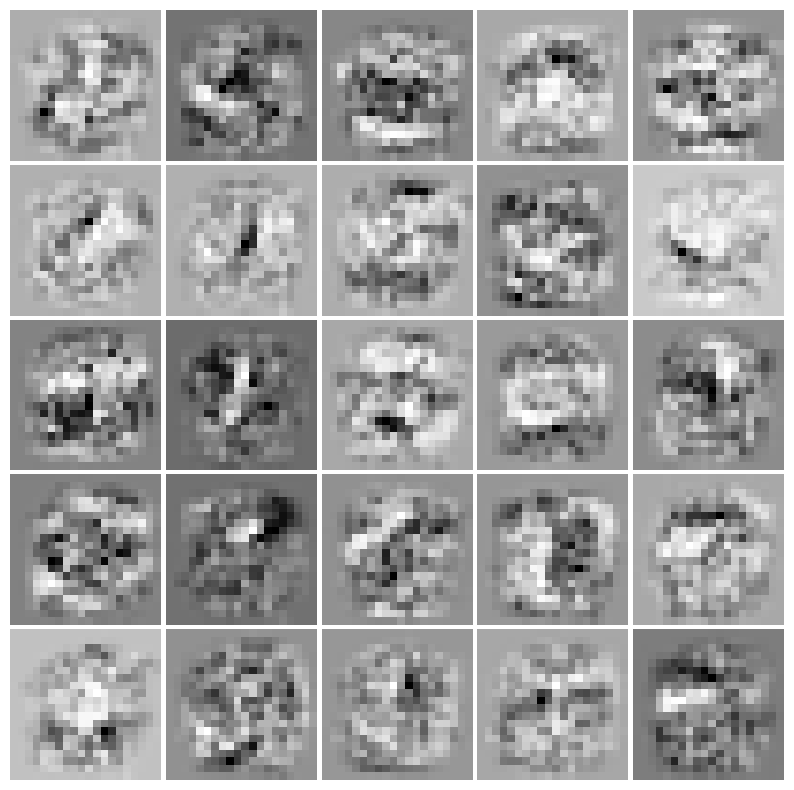

In [23]:
displayData(Theta1[:, 1:])